In [1]:
#importing packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import cv2
import os
import glob

%matplotlib inline

In [2]:
# plot two images
def plot_2_images(_im1, _im2, _text1, _text2):
    plt.figure(figsize=(17,9))
    plt.subplot(1,2,1)
    if (len(_im1.shape)==3):
        plt.imshow(_im1)
    else:
        plt.imshow(_im1,cmap='gray')
    plt.title(_text1)
    plt.subplot(1,2,2)
    if (len(_im2.shape)==3):
        plt.imshow(_im2)
    else:
        plt.imshow(_im2,cmap='gray')
    plt.title(_text2)
    
# plots images
def plot_images(_ims,_names):
    _n_images = len(_ims)
    _figsize = (17, _n_images*2)
    # initialize
    plt.figure(figsize = _figsize)
    _plot_shape = (_n_images//2, 2)         # to display calibration images
    
    for k in range(_n_images):
        plt.subplot(_plot_shape[0],_plot_shape[1],k+1)
        if (len(_ims.shape) == 4):
            plt.imshow(_ims[k])
        else:
            plt.imshow(_ims[k],cmap='gray')
        plt.title(_names[k])

# The calibrate function takes the corner numbers (NX,NY) as inputs and returns 
# (1) camera transformation mtx, and
# (2) distortion coefficients dist
def calibrate(_nx,_ny):
    #initialize arrays to hold coordinates for transformation
    objpoints = []   #3D in real world space (i.e. not distorted)
    imgpoints = []   #2D points in image plane (distorted)

    #allocate object points
    objp = np.zeros((_nx*_ny,3),np.float32)  #3 for x,y,z
    objp[:,:2] = np.mgrid[0:_nx,0:_ny].T.reshape(-1,2)  #2 for x & y coordinates

    # get all calibration-image filenames
    _fnames = glob.glob("camera_cal/calibration*.jpg")
    cal_images = len(_fnames)
    print('Found {} images to calibrate'.format(cal_images))

    # initialize
    plt.figure(figsize=(17,17))
    images = (5, 4)         # to display calibration images
    k = 1       # indexing
    successful_images = 0   # images that were calibrated

    for fname in _fnames:
        _im    = mpimg.imread(fname)
        _gray  = cv2.cvtColor(_im,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(_gray,(_nx,_ny),None) 
        
        _fn   = fname.split('/')
        _name = _fn[1]
        if(ret):
            successful_images += 1 
            objpoints.append(objp)
            imgpoints.append(corners)
            text = 'Calibrated\n' + _name
        else:
            text = 'Not calibrated\n' + _name
          
        # superimpose image with corners
        _im_sup = cv2.drawChessboardCorners(_im, (_nx,_ny), corners, ret)    
        plt.subplot(images[0],images[1],k)
        plt.imshow(_im_sup)
        plt.title(text)
        k = k+1

    print('Used  {} images for calibration'.format(successful_images))
    # calibration points (objpoints, imgpoints) --> camera transformation (mtx) and distrtion coef (dist)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, _gray.shape[::-1], None, None)
    np.set_printoptions(precision=3)
    print('distortion coefficients = {}'.format(dist))
    return(mtx,dist)    

        
# reads / undistorts images and converts to color space of RGB, HLS and grayscale
def get_images(_mtx, _dist, _path):
    _fnames = glob.glob(_path)
    _n_images = len(_fnames)
    print("Found {} images: ".format(_n_images),end = '')
    names = list()
    for i in range(_n_images):
        _out = _fnames[i].split('/')
        names.append(_out[1])
        print(names[i],', ', end='')

    _shape = (mpimg.imread(_fnames[0])).shape   # read an image
    im_raw = np.zeros((_n_images,_shape[0],_shape[1],_shape[2])).astype(np.uint8)
    im_rgb = np.zeros((_n_images,_shape[0],_shape[1],_shape[2])).astype(np.uint8)
    im_gry = np.zeros((_n_images,_shape[0],_shape[1])).astype(np.uint8)
    im_hls = np.zeros((_n_images,_shape[0],_shape[1],_shape[2])).astype(np.uint8)
    
    for k, fname in enumerate(_fnames):
        im_raw[k] = mpimg.imread(fname)
        im_rgb[k] = cv2.undistort(im_raw[k], _mtx, _dist, None, _mtx)
        im_gry[k] = cv2.cvtColor(im_rgb[k],cv2.COLOR_RGB2GRAY) 
        im_hls[k] = cv2.cvtColor(im_rgb[k],cv2.COLOR_RGB2HLS) 
    return(im_raw, im_rgb, im_gry, im_hls, names)

#mask: from first project

# Mask offsets -->  mask vertices
def get_vertices(img,offsets):
    image_size = img.shape
    vertices = np.zeros_like(offsets)
    vertices[0,0,0] = offsets[0,0,0]
    vertices[0,0,1] = image_size[0]-offsets[0,0,1]
    vertices[0,1,0] = offsets[0,1,0]
    vertices[0,1,1] = offsets[0,1,1]
    vertices[0,2,0] = image_size[1] - offsets[0,2,0]
    vertices[0,2,1] = offsets[0,2,1]
    vertices[0,3,0] = image_size[1] - offsets[0,3,0]
    vertices[0,3,1] = image_size[0] - offsets[0,3,1]
    return(vertices)

# Applies a mask on an image
def mask_image(_im, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(_im)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(_im.shape) > 2:
        channel_count = _im.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    # AP: added mask as a return object to help with optimization
    masked_image = cv2.bitwise_and(_im, mask)
    return(masked_image, mask)

# takes a greyscale image and returns binary image after threshholding
def get_binary(_im, _thr):
    _im_bin = np.zeros_like(_im) #black
    _im_bin[(_im > _thr[0]) & (_im <= _thr[1])] = 1
    return(_im_bin)

# takes gradient in x, or y, or magnitude or in direction
def get_grad_bin(_im,ks,thr,mode):
    # ks = kernel size
    # mode = 'x', 'y', 'm' (magnitude), 'd' (direction)
    assert (mode == 'x') |   (mode == 'y') | (mode == 'm') | (mode == 'd')
    sx =np.absolute(cv2.Sobel(_im,cv2.CV_64F,1,0,ksize=ks))
    sy =np.absolute(cv2.Sobel(_im,cv2.CV_64F,0,1,ksize=ks))
    
    if (mode=='x'):
        img = np.uint8(sx*255/np.max(sx))      
    elif (mode=='y'):
        img = np.uint8(sy*255/np.max(sy)) 
    elif (mode == 'm'):
        s = np.sqrt(sx**2 + sy**2)
        img = np.uint8(s*255/np.max(s))
    else:
        img = np.arctan2(sy,sx)
    return(get_binary(img,thr))

def detect_edge(im,thr_r,thr_s,k_s,mode_s):
    im_s         = cv2.cvtColor(im,cv2.COLOR_RGB2HLS) 
    bin_red      = get_binary(im[:,:,0],thr_r)
    bin_sat      = get_grad_bin(im_s[:,:,2],k_s,thr_s,mode_s)
    bin_c        = np.zeros_like(bin_red)
    bin_c[(bin_red == 1) | (bin_sat == 1)] = 1
    return(bin_c,bin_red,bin_sat)

# picks 4 points, determine perspective transformation (P) and its inverse (P_inv)
def get_perspective_tx(img,option):
    %matplotlib inline
    
    if (option == 1):
        # for index of image 5
        src = np.float32([[315,650],[592,450],[1000,650],[690,450]])
        dst = np.float32([[350,675],[350,100],[950,675],[950,100]])
    elif (option == 2):
        # for index of image 5
        src = np.float32([[315,650],[557,475],[1000,650],[730,475]])
        dst = np.float32([[350,675],[350,100],[950,675],[950,100]])
    elif (option == 3):
        # for index of image 5
        src = np.float32([[315,650],[525,500],[1000,650],[767,500]])
        dst = np.float32([[350,675],[350,200],[950,675],[950,200]])
    elif (option == 4):
        # for index of image 6
        src = np.float32([[255,685],[610,440],[1050,685],[669,440]])
        dst = np.float32([[350,675],[350,100],[950,675],[950,100]])
    
    # test the points
    plt.figure(figsize=(17,9))
    plt.imshow(img)
    for i in range(4):
        plt.plot(src[i,0],src[i,1],'x')   
        plt.plot(dst[i,0],dst[i,1],'o')
    
    # get transform
    P     = cv2.getPerspectiveTransform(src,dst)
    P_inv = cv2.getPerspectiveTransform(dst,src)
    return(P, P_inv)

# picks non-zero coordinates of a binary imapge
def get_nz_coordinates(im):
    nonzero  = im.nonzero()  # gives 2 dimensional vector
    nz_y = np.array(nonzero[0])
    nz_x = np.array(nonzero[1])
    return(nz_x, nz_y)

# evaluates 2 polynomials: left and right
def eval_poly(poly_l, poly_r, rows):
    y = np.linspace(0, rows-1, rows).astype(np.int32)
    curve_l = (np.polyval(poly_l,y)).astype(np.int32)
    curve_r = (np.polyval(poly_r,y)).astype(np.int32)
    return(curve_l, curve_r, y)

# adds two polynomials on top of an image
def plot_poly(im, poly_l, poly_r):
    curve_l, curve_r, y = eval_poly(poly_l, poly_r,  im.shape[0])
    im[y,curve_l] = [255,255,0]
    im[y,curve_r] = [255,255,0]
    return(im, curve_l, curve_r, y)

# given coef (a,b) and y position finds radius
def get_radius(a,b,y):
    # assume lane is 30 meters long and 3.7 meters wide
    # Define conversions in x and y from pixels space to meters
    radius = ((1 + (2*a*y + b)**2)**1.5) / np.absolute(2*a)
    return(radius)

# for initial frame get right/left lane positions
def get_base_points(im):
    rows         = im.shape[0]
    columns      = im.shape[1]
    midpoint = np.int(columns//2)
    histogram      = np.sum(im[rows//2:,:], axis=0)
    left_base_pos  = int(np.argmax(histogram[:midpoint]))
    right_base_pos = int(np.argmax(histogram[midpoint:]) + midpoint)
    return(left_base_pos,right_base_pos,histogram)

# given a binary image and initial estimates return polynomial fit 
def get_poly_fit_1st_frame(im_in, n_win=9, margin=100, minpix=50):
    xpos_l, xpos_r, _ = get_base_points(im_in) 
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzerox, nonzeroy = get_nz_coordinates(im_in)
    
    # Initialize current positions
    leftx_current  = xpos_l
    rightx_current = xpos_r
    
    # Create lists to receive left and right lane pixel indices
    left_lane_inds = list()
    right_lane_inds = list()
    
    # set visualization image for output, black or white
    # plot (1) rectangles, (2) hot pixels, (3) poly fit
    img_vis = np.dstack((im_in, im_in, im_in))*255
    
    rows = im_in.shape[0]
    window_height = np.int(rows/n_win)
    for window in range(n_win):
        # (I) add rectangular windows
        # window boundaries both for right and left lanes
        y_b   = rows - (window+1)*window_height   # bottom
        y_t   = rows - window*window_height        # top
        xl_l  = leftx_current - margin
        xl_r  = leftx_current + margin
        xr_l = rightx_current - margin
        xr_r = rightx_current + margin
        # plot tectangular windows (in green) on the visualization image
        cv2.rectangle(img_vis,(xl_l,y_b),(xl_r,y_t),(0,255,0), 2) 
        cv2.rectangle(img_vis,(xr_l,y_b),(xr_r,y_t),(0,255,0), 2) 
    
        # (II) identify hot pixels in 2 windows
        temp_l = (nonzeroy >= y_b) & (nonzeroy < y_t) & (nonzerox >= xl_l) & (nonzerox < xl_r)
        temp_r = (nonzeroy >= y_b) & (nonzeroy < y_t) & (nonzerox >= xr_l) & (nonzerox < xr_r)
        good_left_inds  = temp_l.nonzero()[0]
        good_right_inds = temp_r.nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the n_win arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # plot hot pixels
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    img_vis[lefty, leftx]  = [255, 0, 0]
    img_vis[righty, rightx] = [0, 0, 255]
    
    # Fit a second order polynomial to each
    left_poly = np.polyfit(lefty, leftx, 2)
    right_poly = np.polyfit(righty, rightx, 2)
    # plot poynomila fits
    img_vis,_,_,_ = plot_poly(img_vis,left_poly,right_poly)
    
    return(img_vis,left_poly,right_poly)

# given a binary image and initial estimates return all candidate points 
def get_poly_fit(im_in, left_poly, right_poly, margin, x_scale, y_scale,with_plot):
    # identify all non-zero pixel coordinates
    nonzerox, nonzeroy = get_nz_coordinates(im_in)
    
    # find x positions if pixels were on left lane
    left_ideal_x = (np.polyval(left_poly,nonzeroy)).astype(np.int32)
    # find indices within left lane margin
    left_lane_inds =  ((nonzerox > (left_ideal_x -  margin)) & (nonzerox < (left_ideal_x + margin))) 
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    
    right_ideal_x = (np.polyval(right_poly,nonzeroy)).astype(np.int32)
    right_lane_inds = ((nonzerox > (right_ideal_x - margin)) & (nonzerox < (right_ideal_x + margin))) 
    # Extract left and right line pixel positions
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (with_plot):
        # initialize visualization image to birds eye view, with all non-zero pixels in white
        img_vis = np.dstack((im_in, im_in, im_in))*255
        # set all detected left lane pixels to red 
        img_vis[lefty, leftx]   = [255, 0, 0]
        # set all detected right lane pixels to  to blue
        img_vis[righty, rightx] = [0, 0, 255]
        result = img_vis
    else:
        result = img_vis
    
    # Generate new poly x 
    p_l_p  = np.polyfit(lefty, leftx, 2)
    p_r_p  = np.polyfit(righty, rightx, 2)
    
    if(with_plot):
        # plot left/right poylynomials in yellow
        left_fitx, right_fitx, ploty = eval_poly(p_l_p, p_r_p, im_in.shape[0])
        img_vis[ploty,left_fitx] = [0,0,0]
        img_vis[ploty,right_fitx] = [0,0,0]
    
        # Create an image to show the selection window
        window_img = np.zeros_like(img_vis)
        # generate a polygon & recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(img_vis, 1, window_img, 0.3, 0)
    else:
        result = im_in 
    
    #  redo polifit for new scale
    # Fit new polynomials to x,y in world space
    lefty_new =  lefty * y_scale
    leftx_new =  leftx * x_scale
    righty_new = righty * y_scale
    rightx_new = rightx * x_scale
    p_l_m = np.polyfit(lefty_new, leftx_new, 2)
    p_r_m = np.polyfit(righty_new, rightx_new, 2)
    return(result,p_l_p,p_r_p,p_l_m,p_r_m)

# adds lane highlighted 
def add_lane(im_in,p_l,p_r):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(im_in).astype(np.uint8)
    # get poly curves
    left_fitx, right_fitx, ploty = eval_poly(p_l, p_r, im_in.shape[0])
    # get offset position
    left_pos, right_pos = left_fitx[-1], right_fitx[-1]
    car_pos = (left_pos+ right_pos)/2
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    _im_shape = (color_warp.shape[1], color_warp.shape[0])
    newwarp = cv2.warpPerspective(color_warp, P_inv,_im_shape)
    # Combine the result with the original image
    _im_out = cv2.addWeighted(im_in, 1, newwarp, 0.3, 0)
    return(_im_out, car_pos)

In [3]:
# this class remembers the state of lanes
class state():
    def __init__(self,_alpha,_beta,_y_pos,_y_scale,_x_scale):
        self.alpha  = _alpha                       # poly low pass coefficient
        self.beta   = _beta                        # radius/offset low pass coefficient
        self.y         = _y_pos * _y_scale         # y position of radius
        self.x_scale   = _x_scale
        self.radius    = None
        self.offset    = 0
        self.alpha_bar = 1-self.alpha              # complement of alpha
        self.beta_bar  = 1-self.beta               # complement of beta
        self.poly_l    = None                      # left polynomial
        self.poly_r    = None                      # right polynomial
        self.poly_l_m  = None                      # left polynomial in meters
        self.poly_r_m  = None                      # right polynomial in meters
        # for text on image
        self.c      = (255,255,255)
        self.font   = cv2.FONT_HERSHEY_SIMPLEX
    
    def get_radius(self):
        r_l = get_radius(self.poly_l_m[0],self.poly_l_m[1],self.y)
        r_r = get_radius(self.poly_r_m[0],self.poly_r_m[1],self.y)
        #if ( (abs(r_l/r_r) > 3) | ((abs(r_l/r_r) < 1/3))):
        #    r = None
        #else:
        r = (r_l+r_r)/2
        return(r)
    
    def get_offset(self,im):
        left_fitx, right_fitx, ploty = eval_poly(self.poly_l, self.poly_r, self.y+1)
        # get offset position
        left_pos, right_pos = left_fitx[-1], right_fitx[-1]
        car_pos = (left_pos+ right_pos)/2
        ideal_pos = im.shape[1]/2
        offset = self.x_scale*(car_pos - ideal_pos)
        return(offset)
    
    def update_radius(self,r):
        if (self.radius == None):
            self.radius = r
        elif (r!=None):
            self.radius = self.beta * self.radius + self.beta_bar * r 
    
    def update_left_poly_pixel(self, p):
        if (self.poly_l == None):
            self.poly_l = p
        elif (p!=None):
            self.poly_l = self.alpha * self.poly_l + self.alpha_bar * p 
    
    def update_right_poly_pixel(self, p):
        if (self.poly_r == None):
            self.poly_r = p
        elif (p!=None):
            self.poly_r = self.alpha * self.poly_r + self.alpha_bar * p
    
    def update_left_poly_meter(self, p):
        if (self.poly_l_m == None):
            self.poly_l_m = p
        elif (p!=None):
            self.poly_l_m = self.alpha * self.poly_l_m + self.alpha_bar * p 
    
    def update_right_poly_meter(self, p):
        if (self.poly_r_m == None):
            self.poly_r_m = p
        elif (p != None):
            self.poly_r_m = self.alpha * self.poly_r_m + self.alpha_bar * p
    
    def update_offset(self,_offset):
        if (_offset != None):
            self.offset = self.beta * self.offset + self.beta_bar * _offset

    def update_state(self, im,poly_l,poly_r,poly_l_m,poly_r_m): 
        # (a) polynomials
        self.update_left_poly_pixel(poly_l)
        self.update_right_poly_pixel(poly_r)
        self.update_left_poly_meter(poly_l_m)
        self.update_right_poly_meter(poly_r_m)
        # (b) radius
        r     = self.get_radius()
        self.update_radius(r)
        # (c) offcenter
        _offset = self.get_offset(im)
        self.update_offset(_offset)
        
        if (self.radius != None):
            cv2.putText(im, 'radius       = {:.0f} m'.format(self.radius), (475,55), self.font, 1, self.c, 4)
        cv2.putText(im, 'car position = {:.2f} m'.format(self.offset), (475,90), self.font, 1, self.c, 4)
        return(im, self.poly_l,self.poly_r)

In [4]:
# parameters
NX, NY       = 9,6                                               #calibration parameters
MASK_OFFSETS = np.array([[(80,0),(550,440),(550,440),(80,0)]])   #polygon relative corners for masking
THR_RED      = 190, 256                                          # red threshold (220)
THR_SAT      = 20, 256                                           # saturation + gradient (80)
KS           = 11                                                # kernel length
MODE         = 'x'                                               # gradient type
MARGIN       = 60                                                # the width of the windows +/- marg
NWINDOWS     = 9                                                 # number of sliding windows, for first frame
MINPIX       = 50                                                # threshold for minimum number of pixels 
ALPHA        = 0.9                                               # polynomial low pass filter
BETA         = 0.9                                              # radius/offset low pass filter
Y_M_P        = 23/720                                            # 30/720 # meters per pixel in y dimension
X_M_P        = 3.7/700                                           # meters per pixel in x dimension
Y_EVAL       = 719                                               # evaluate radius at this y-position

### PART I: CALIBRATION

Found 20 images to calibrate
Used  17 images for calibration
distortion coefficients = [[ -2.355e-01  -7.904e-02  -1.285e-03   8.260e-05   7.227e-02]]


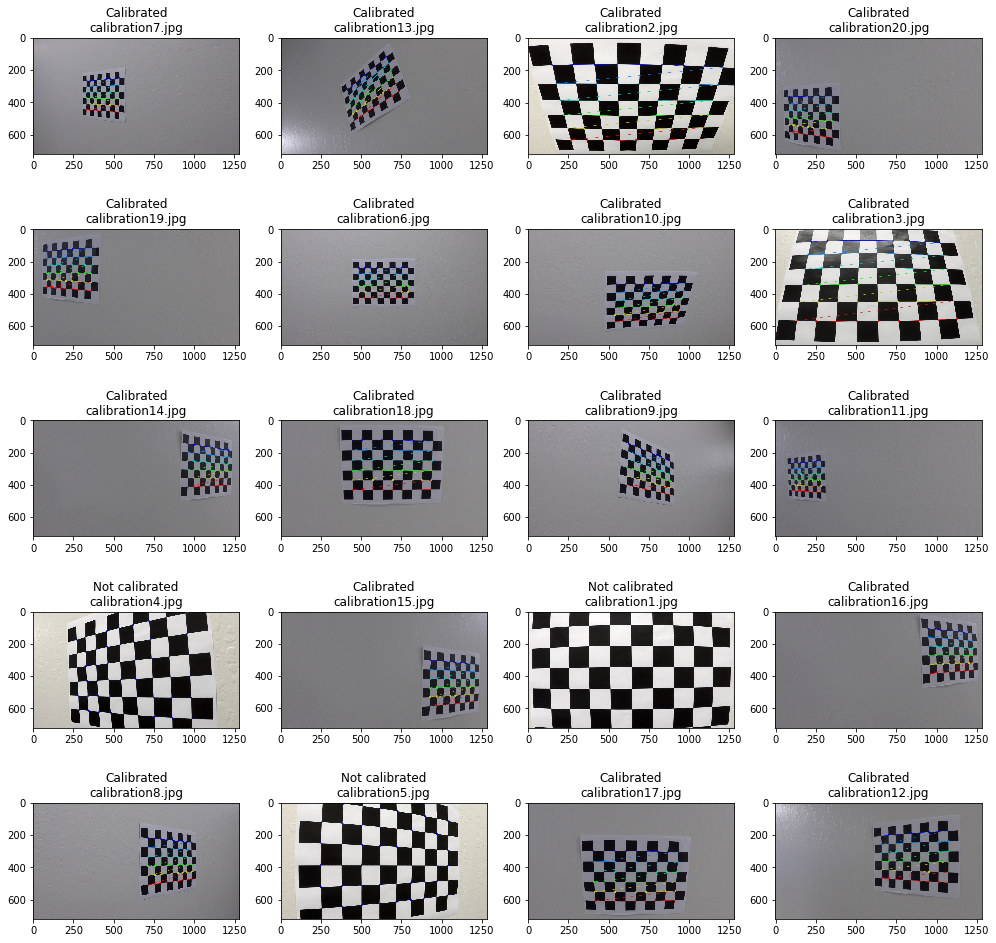

In [5]:
# run calibration
MTX, DIST = calibrate(NX,NY)

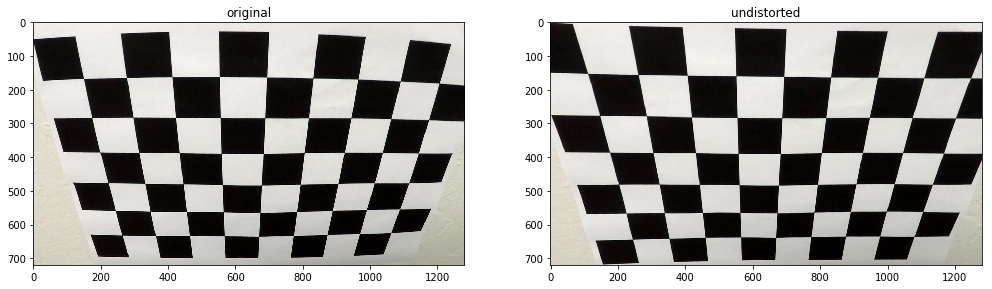

In [6]:
_fn     = "camera_cal/calibration2.jpg"
_im = mpimg.imread(_fn)
_dst = cv2.undistort(_im, MTX, DIST, None, MTX)
plot_2_images(_im,_dst,'original','undistorted')

### (II) COLOR SPACE FOR LANE DETECTION

Found 8 images: test6.jpg , test4.jpg , test1.jpg , test2.jpg , test5.jpg , straight_lines2.jpg , straight_lines1.jpg , test3.jpg , 

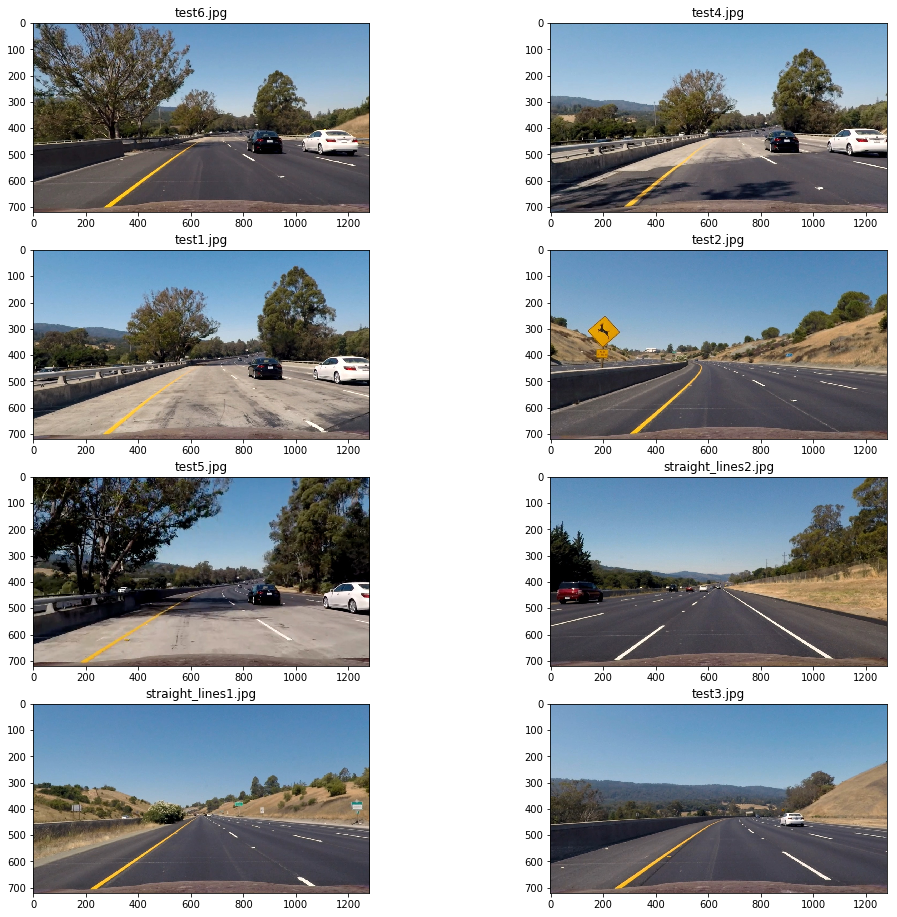

In [7]:
# read and plot test images

_path = "test_images/*.jpg"
#_path = "debug/*.jpg"
images_raw, images_rgb, images_gry, images_hls, names = get_images(MTX,DIST,_path)
plot_images(images_rgb,names)

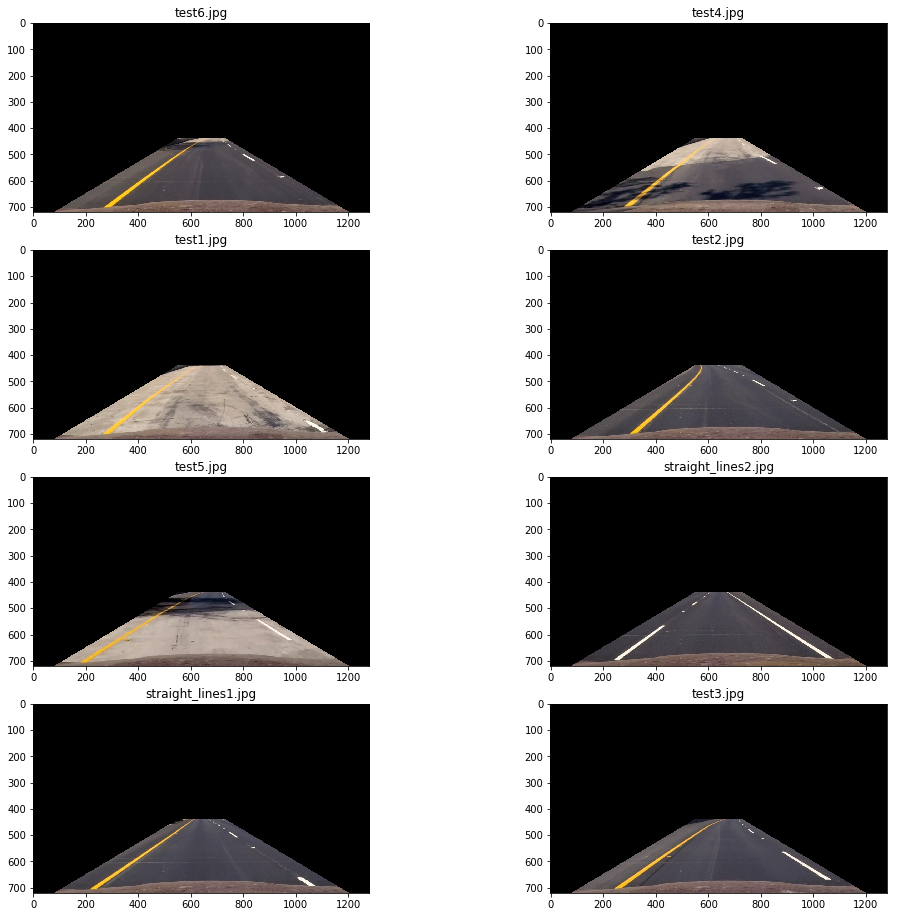

In [8]:
# setup mask
VERTICES = get_vertices(images_rgb[0],MASK_OFFSETS)
masked   = np.zeros_like(images_rgb).astype(np.uint8)
n_images = len(images_rgb)
for i in range(n_images):
    masked[i], _   = mask_image(images_rgb[i], VERTICES)
plot_images(masked,names)

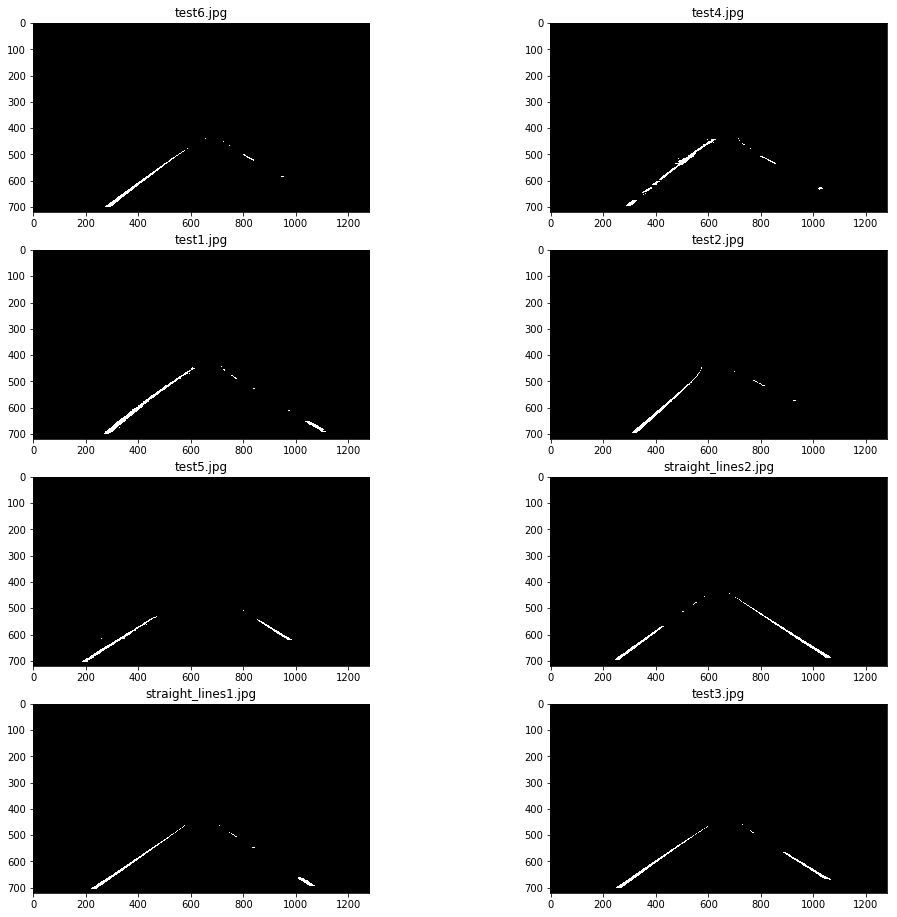

In [9]:
# experiment with red thresholds without gradient
thr_red = 220,256
# stack of images
images_red = np.zeros_like(images_gry).astype(np.uint8)
for i in range(len(images_red)):
    _bin = get_binary(images_rgb[i,:,:,0],thr_red)
    images_red[i], _  = mask_image(_bin, VERTICES)

plot_images(images_red,names)

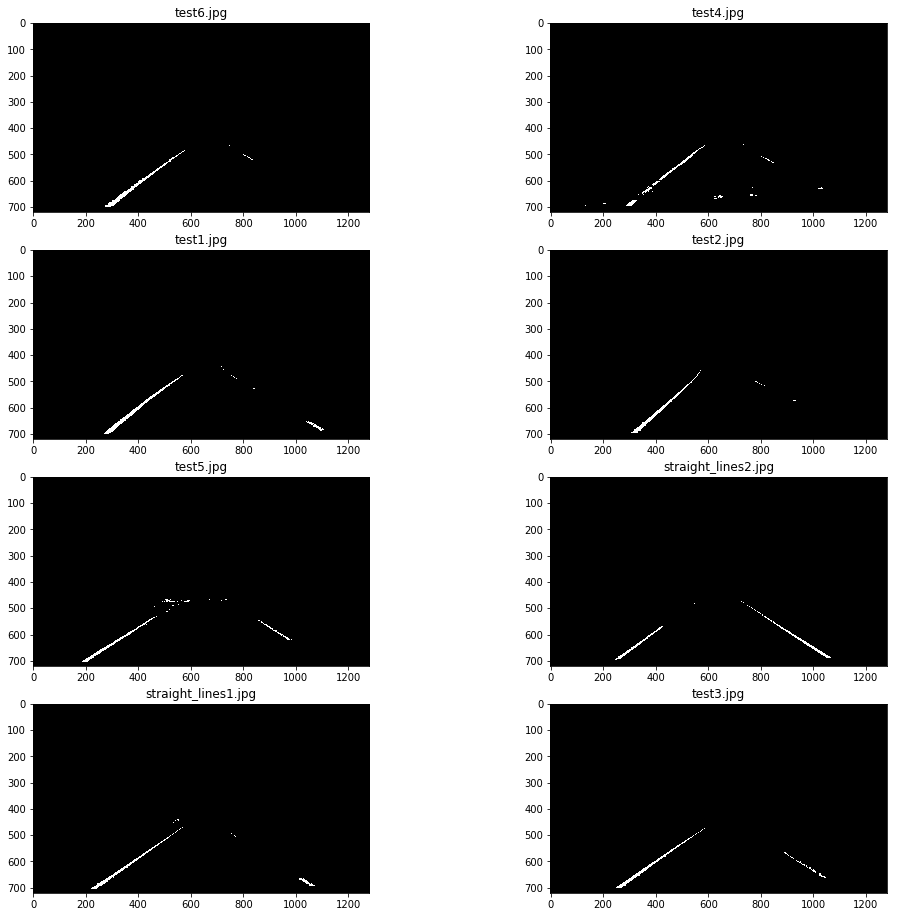

In [10]:
# experiment with saturation thresholds without gradient
thr_sat  = 170,256
images_sat = np.zeros_like(images_gry).astype(np.uint8)
for i in range(len(images_sat)):
    _bin = get_binary(images_hls[i,:,:,2],thr_sat)
    images_sat[i], _  = mask_image(_bin, VERTICES)

plot_images(images_sat,names)

### (III) GRADIENT FOR LANE DETECTION

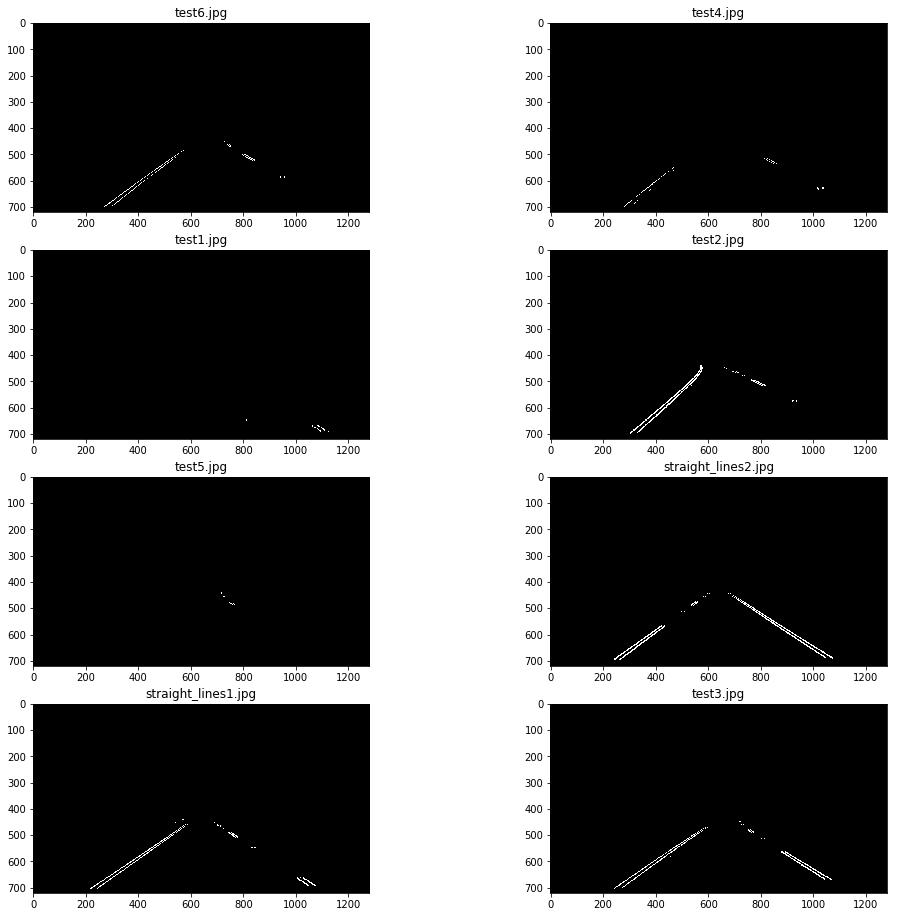

In [11]:
# experimentation with gradient (section 20, test3)
# note: gray is fine except if sunny
thr_grad  = (70,255)    #section 21
ks        = 15
mode      = 'x'        #gradient across x-dimension

images_gry_grad = np.zeros_like(images_gry).astype(np.uint8)
for i in range(len(images_gry)):
    _bin            = get_grad_bin(images_gry[i,:,:],ks,thr_grad,mode)
    images_gry_grad[i], _= mask_image(_bin, VERTICES)
plot_images(images_gry_grad,names)

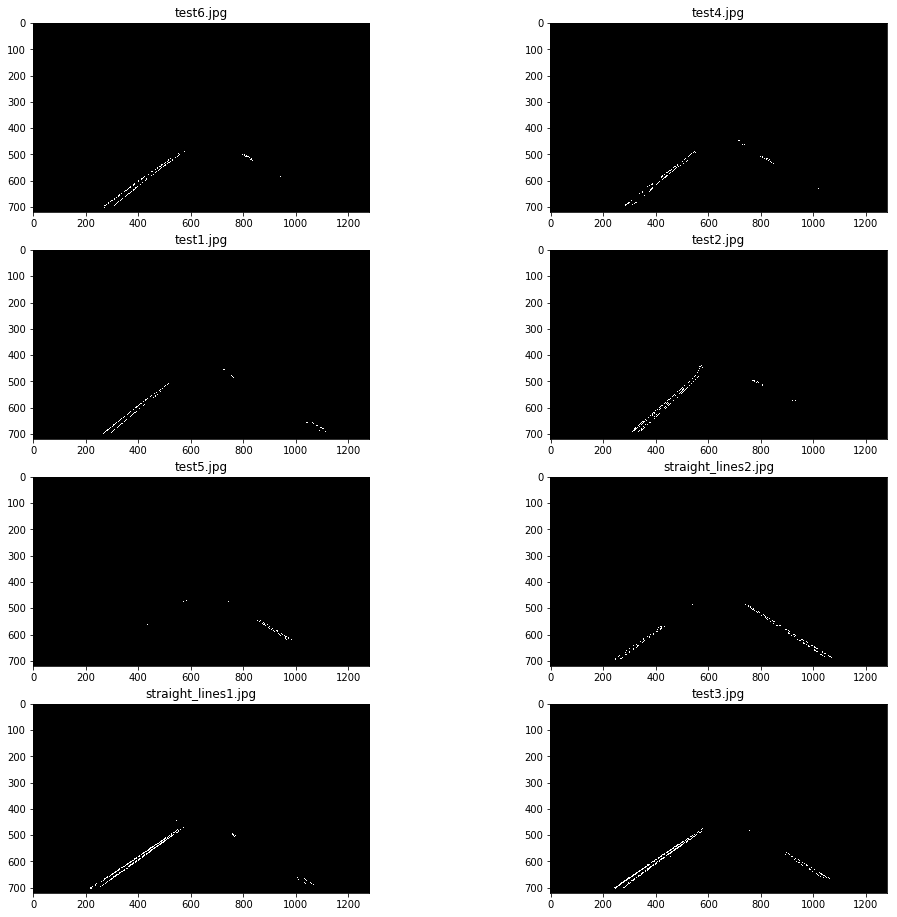

In [12]:
# experimentation with gradient (section 20, test3)
# note: play with saturation
thr_hls  = (70,100)    #section 21
ks        = 11
mode      = 'x'        #gradient across x-dimension

images_hls_grad = np.zeros_like(images_gry).astype(np.uint8)
for i in range(len(images_gry)):
    _bin             = get_grad_bin(images_hls[i,:,:,2],ks,thr_hls,mode)
    images_hls_grad[i], _= mask_image(_bin, VERTICES)
plot_images(images_hls_grad,names)

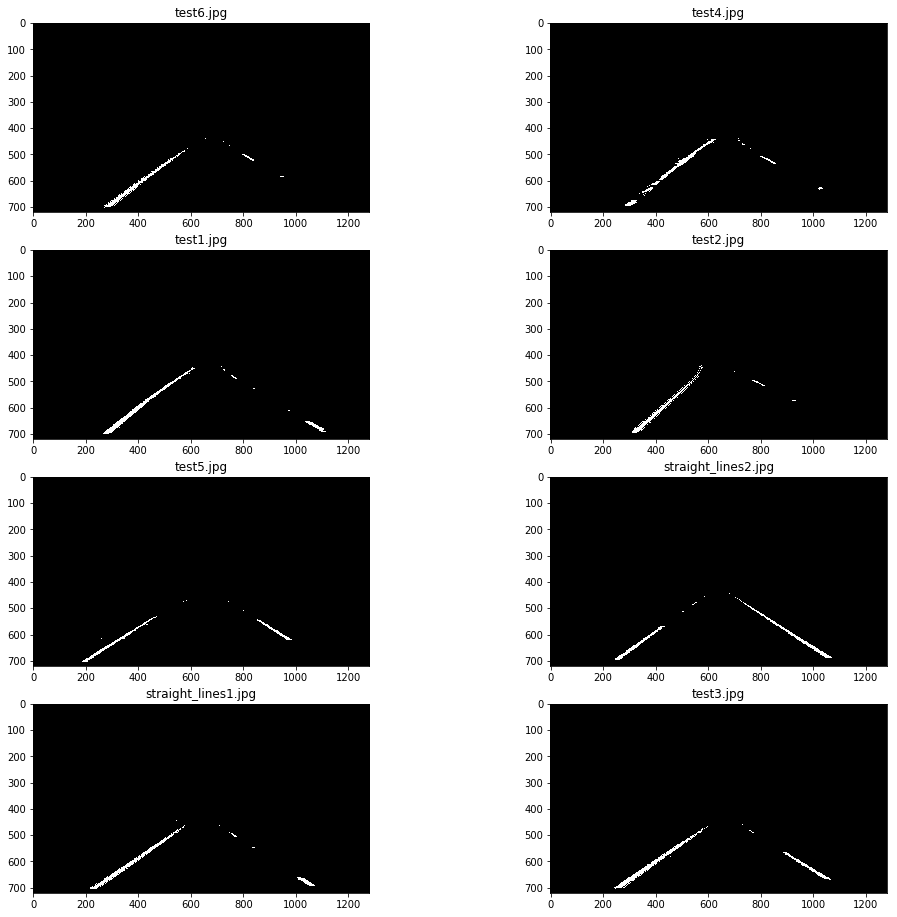

In [13]:
# combine red and sat-grad

combined = np.zeros_like(images_gry).astype(np.uint8)

thr_red = (220,256)
thr_sat = (70,100)
ks        = 11
mode      = 'x'        #gradient across x-dimension

for i in range(len(images_gry)):
    bin_c,_,_ = detect_edge(images_rgb[i],thr_red,thr_sat,ks,mode)
    combined[i], _= mask_image(bin_c, VERTICES)

plot_images(combined,names)

### (IV) PERSPECTIVE TRANSFORMATION: BIRD EYE VIEW

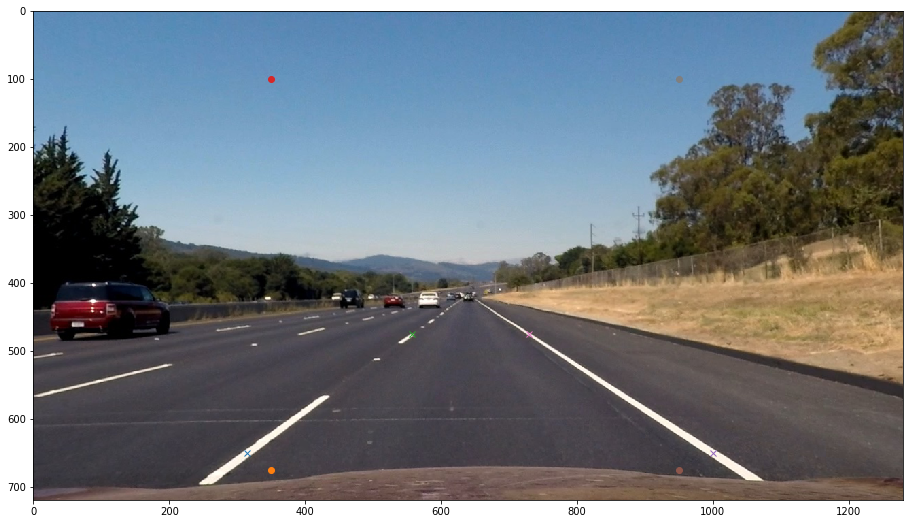

In [14]:
P, P_inv = get_perspective_tx(images_rgb[5],2)

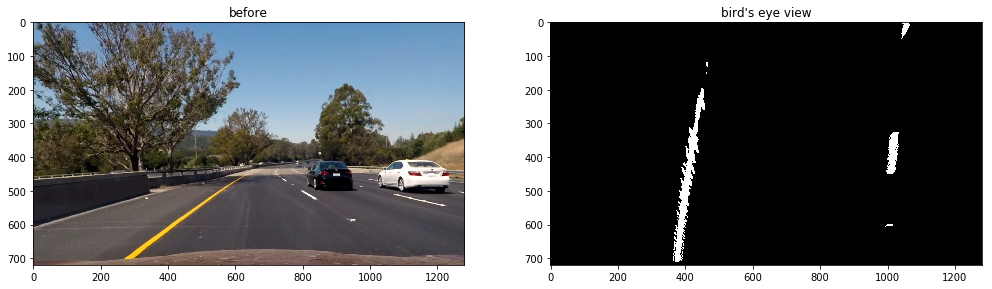

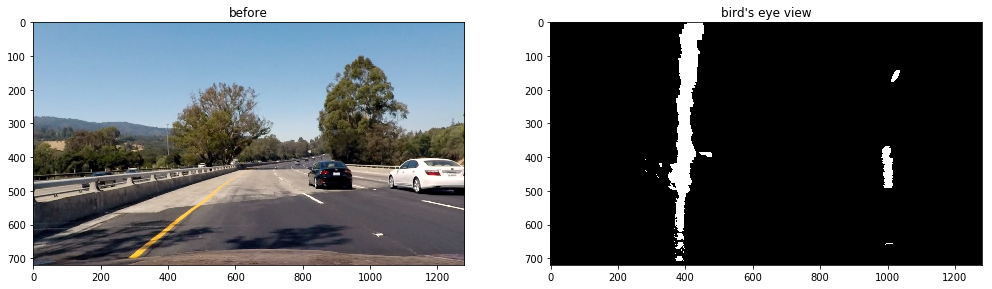

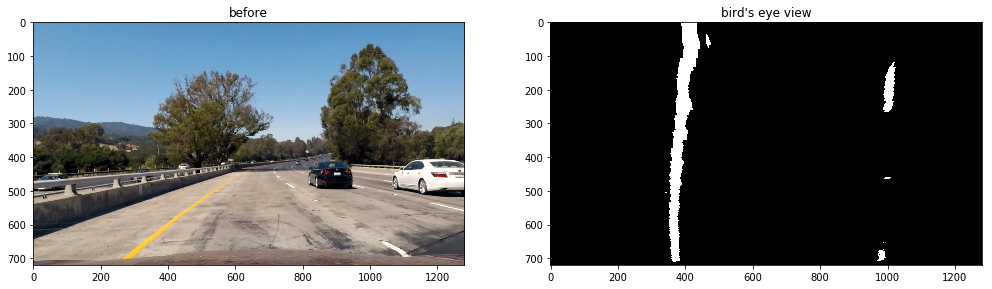

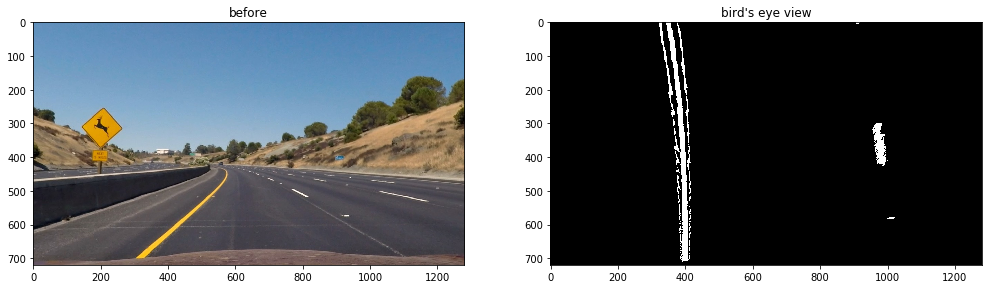

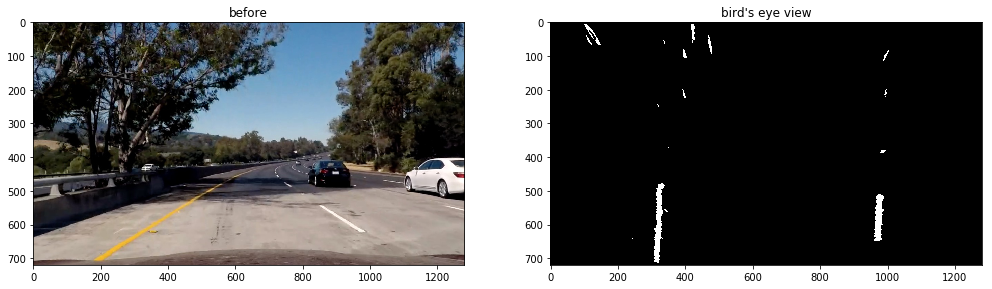

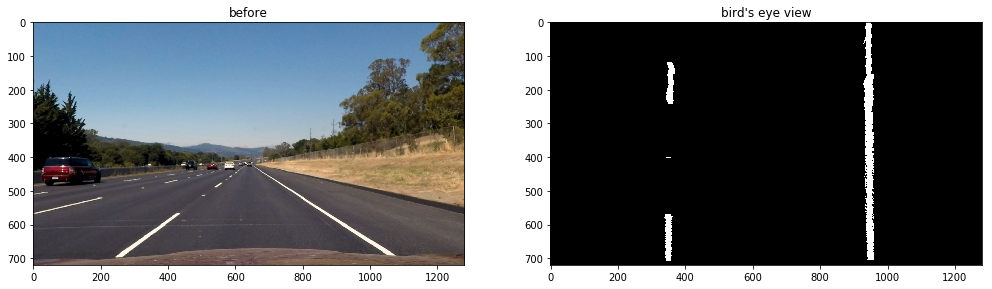

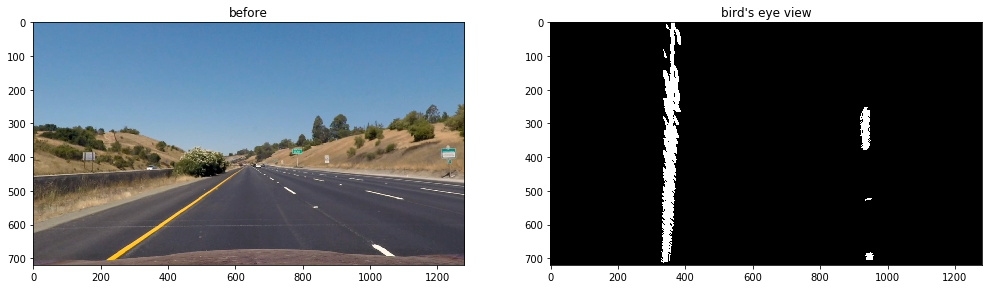

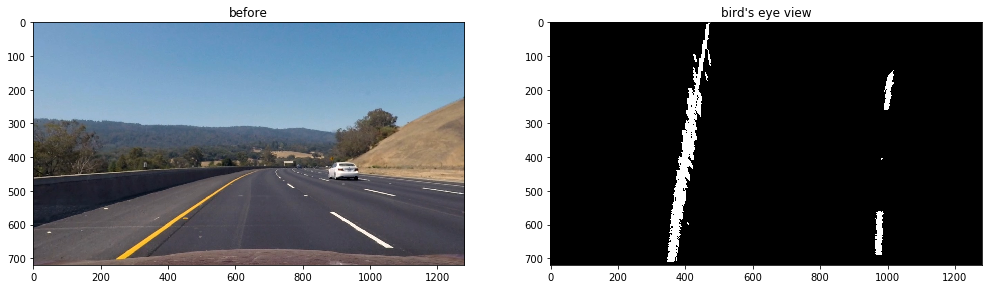

In [15]:
# bird's eye view
bev = np.zeros_like(images_gry).astype(np.uint8)
for i in range(n_images):
    im_in = combined[i]
    im_shape = (im_in.shape[1], im_in.shape[0])
    bev[i] = cv2.warpPerspective(im_in, P, im_shape, flags=cv2.INTER_LINEAR)
    plot_2_images(images_rgb[i],bev[i],"before","bird's eye view")

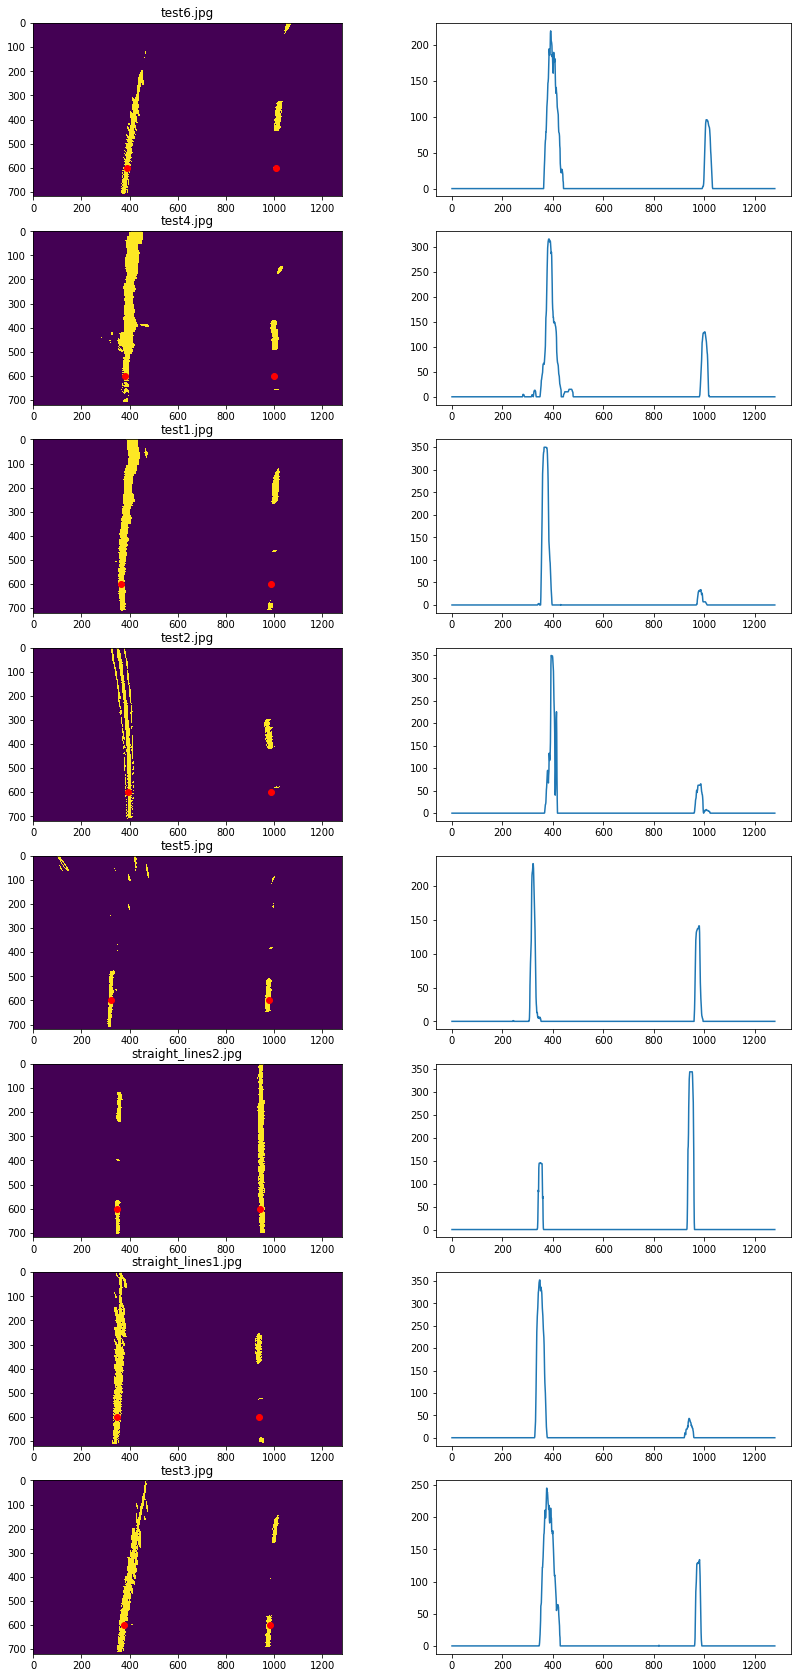

In [16]:
# get initial left/right lane base X values
hstgrm    = np.zeros((n_images,1280)).astype(np.int32)
left_base = np.zeros(n_images).astype(np.int32)
right_base = np.zeros(n_images).astype(np.int32)

plt.figure(figsize=(14,30))
plot_shape = (n_images, 2)         # to display calibration images

for i in range(n_images):
    left_base[i], right_base[i], hstgrm[i] = get_base_points(bev[i])

    plt.subplot(plot_shape[0],plot_shape[1],2*i+1)
    plt.imshow(bev[i])
    plt.title(names[i])
    plt.plot(left_base[i],600,'or')
    plt.plot(right_base[i],600,'or')
    plt.subplot(plot_shape[0],plot_shape[1],2*i+2)
    plt.plot(hstgrm[i])

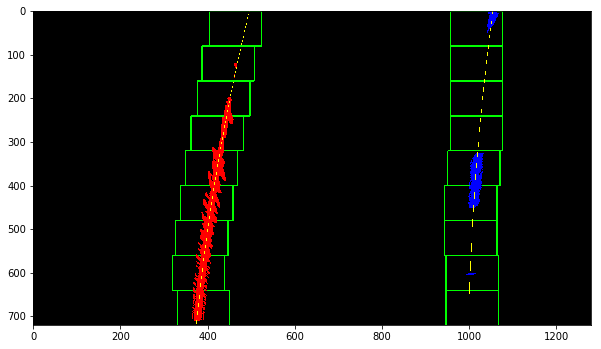

In [17]:
### First frame
# choose a test image
index = 0
img_out,p_l,p_r = get_poly_fit_1st_frame(bev[index], NWINDOWS, MARGIN, MINPIX)
plt.figure(figsize=(10,8))
plt.imshow(img_out);

Left : quad. coef. = 5.24e-04, radius = 954.538 m
Right: quad. coef. = 3.96e-04, radius = 1261.791 m


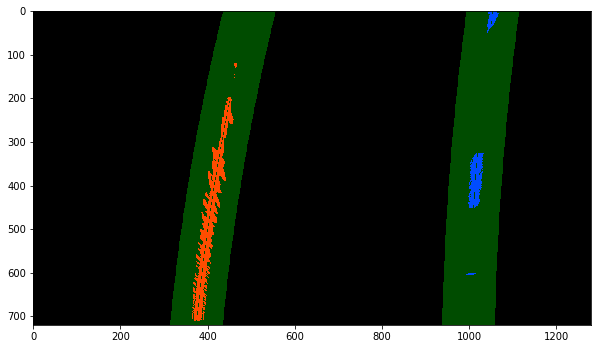

In [18]:
### After initial frame
# choose a test image
index = 0
# Set the width of the windows +/- margin

img_out, poly_l_p, poly_r_p, poly_l_m, poly_r_m = get_poly_fit(bev[index], p_l, p_r, MARGIN, X_M_P, Y_M_P, True)

plt.figure(figsize=(10,8))
plt.imshow(img_out)

left_curverad  = get_radius(poly_l_m[0],poly_l_m[1],Y_EVAL*Y_M_P)
right_curverad = get_radius(poly_r_m[0],poly_r_m[1], Y_EVAL*Y_M_P)
print('Left : quad. coef. = {:.2e}, radius = {:.3f} m'.format(poly_l_m[0],left_curverad))
print('Right: quad. coef. = {:.2e}, radius = {:.3f} m'.format(poly_r_m[0],right_curverad))
# Example values: 632.1 m    626.2 m

In [19]:
# this pipeline uses the following global variables: 
# MTX      (camera cal)
# DIST     (camera cal) 
# THR_RED  (edge detection) 
# VERTICES (mask) 
# P        (perspective tx) 
# NWINDOWS (initial frame) 
# MINPIX   (initial frame)
# MARGIN   (lane detection) 
# X_M_P    (conversion  pixel to meters)
# Y_M_P    (conversion  pixel to meters)

def pipeline(_im):
    global first_time, p_l_avg, p_r_avg
    _im_und = cv2.undistort(_im, MTX, DIST, None, MTX)
    # choose color space
    _im_edg,_,_ = detect_edge(_im_und,THR_RED,THR_SAT,KS,MODE)
    _im_msk,_ = mask_image(_im_edg, VERTICES)
    _im_shape = (_im_msk.shape[1], _im_msk.shape[0])
    _im_bev = cv2.warpPerspective(_im_msk, P, _im_shape, flags=cv2.INTER_LINEAR)
   
    if(first_time):
        _im_out,p_l_avg,p_r_avg = get_poly_fit_1st_frame(_im_bev, NWINDOWS, MARGIN, MINPIX)
        first_time = False
    else:
        #get polynomials
        _im_lne, p_l_p, p_r_p, p_l_m, p_r_m = get_poly_fit(_im_bev, p_l_avg, p_r_avg, MARGIN, X_M_P, Y_M_P,True)
        _im_txt,p_l_avg,p_r_avg = car_state.update_state(_im_und, p_l_p, p_r_p,p_l_m, p_r_m)
        _im_out, car_pos = add_lane(_im_txt, p_l_avg, p_r_avg)
    return(_im_out)

In [20]:
# this pipeline uses the following global variables: 
# MTX      (camera cal)
# DIST     (camera cal) 
# THR_RED  (edge detection) 
# VERTICES (mask) 
# P        (perspective tx) 
# NWINDOWS (initial frame) 
# MINPIX   (initial frame)
# MARGIN   (lane detection) 
# X_M_P    (conversion  pixel to meters)
# Y_M_P    (conversion  pixel to meters)

def pipeline_debug(_im):
    global first_time, p_l_avg, p_r_avg
    _im_und = cv2.undistort(_im, MTX, DIST, None, MTX)
    # choose color space
    _im_edg,_im_r,_im_s = detect_edge(_im_und,THR_RED,THR_SAT,KS,MODE)
    #_im_red = get_binary(_im_und[:,:,0],THR_RED)
    _im_msk,_ = mask_image(_im_edg, VERTICES)
    _im_msk_r,_ = mask_image(_im_r, VERTICES)
    _im_msk_s,_ = mask_image(_im_s, VERTICES)
    _im_shape = (_im_msk.shape[1], _im_msk.shape[0])
    _im_bev = cv2.warpPerspective(_im_msk, P, _im_shape, flags=cv2.INTER_LINEAR)
   
    _im_mult = np.zeros((2*720,2*1280,3)).astype(np.uint8)
    if(first_time):
        _im_out,p_l_avg,p_r_avg = get_poly_fit_1st_frame(_im_bev, NWINDOWS, MARGIN, MINPIX)
        first_time = False
    else:
        #get polynomials
        _im_lne, p_l_p, p_r_p, p_l_m, p_r_m = get_poly_fit(_im_bev, p_l_avg, p_r_avg, MARGIN, X_M_P, Y_M_P,True)
        _im_txt,p_l_avg,p_r_avg = car_state.update_state(_im_und, p_l_p, p_r_p,p_l_m, p_r_m)
        _im_out, car_pos = add_lane(_im_txt, p_l_avg, p_r_avg)
         # multiscreen
        _im_mult[720:,:1280,:] = _im_lne
        _im_mult[:720,:1280,:] = _im_out
        _im_mult[:720,1280:,0] = 255*_im_msk_r
        _im_mult[:720:,1280:,1] =  255*_im_msk_s 
    
    return(_im_mult)

In [21]:
# initialize class state
car_state = state(ALPHA,BETA,Y_EVAL,Y_M_P,X_M_P)

In [22]:
video_in     = 'project_video.mp4'
video_out    = 'P4_video_out.mp4'

first_time    = True
p_l_avg       = 0
p_r_avg       = 0
t_start       = 0
t_end         = None

car_state = state(ALPHA,BETA,Y_EVAL,Y_M_P,X_M_P)

# clip_in includes all the frames
clip_in = VideoFileClip(video_in).subclip(t_start,t_end)

# transform frames
clip_out = clip_in.fl_image(pipeline)

# store
%time clip_out.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video P4_video_out.mp4
[MoviePy] Writing video P4_video_out.mp4


100%|█████████▉| 1260/1261 [02:28<00:00,  8.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_video_out.mp4 

CPU times: user 7min 6s, sys: 3.58 s, total: 7min 9s
Wall time: 2min 29s


In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))

In [24]:
# Challenge
video_in      = 'challenge_video.mp4'
video_out     = 'P4_ch_video_out.mp4'
first_time    = True
p_l_avg       = 0
p_r_avg       = 0
t_start       = 0
t_end         = None

car_state = state(ALPHA,BETA,Y_EVAL,Y_M_P,X_M_P)

# clip_in includes all the frames
clip_in_ch = VideoFileClip(video_in)

# transform frames
clip_out_ch = clip_in_ch.fl_image(pipeline_debug).subclip(t_start,t_end)
#clip_out_ch = clip_in_ch.fl_image(pipeline)

# store
%time clip_out_ch.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video P4_ch_video_out.mp4
[MoviePy] Writing video P4_ch_video_out.mp4


100%|██████████| 485/485 [01:00<00:00,  8.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P4_ch_video_out.mp4 

CPU times: user 2min 36s, sys: 2.4 s, total: 2min 39s
Wall time: 1min


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))

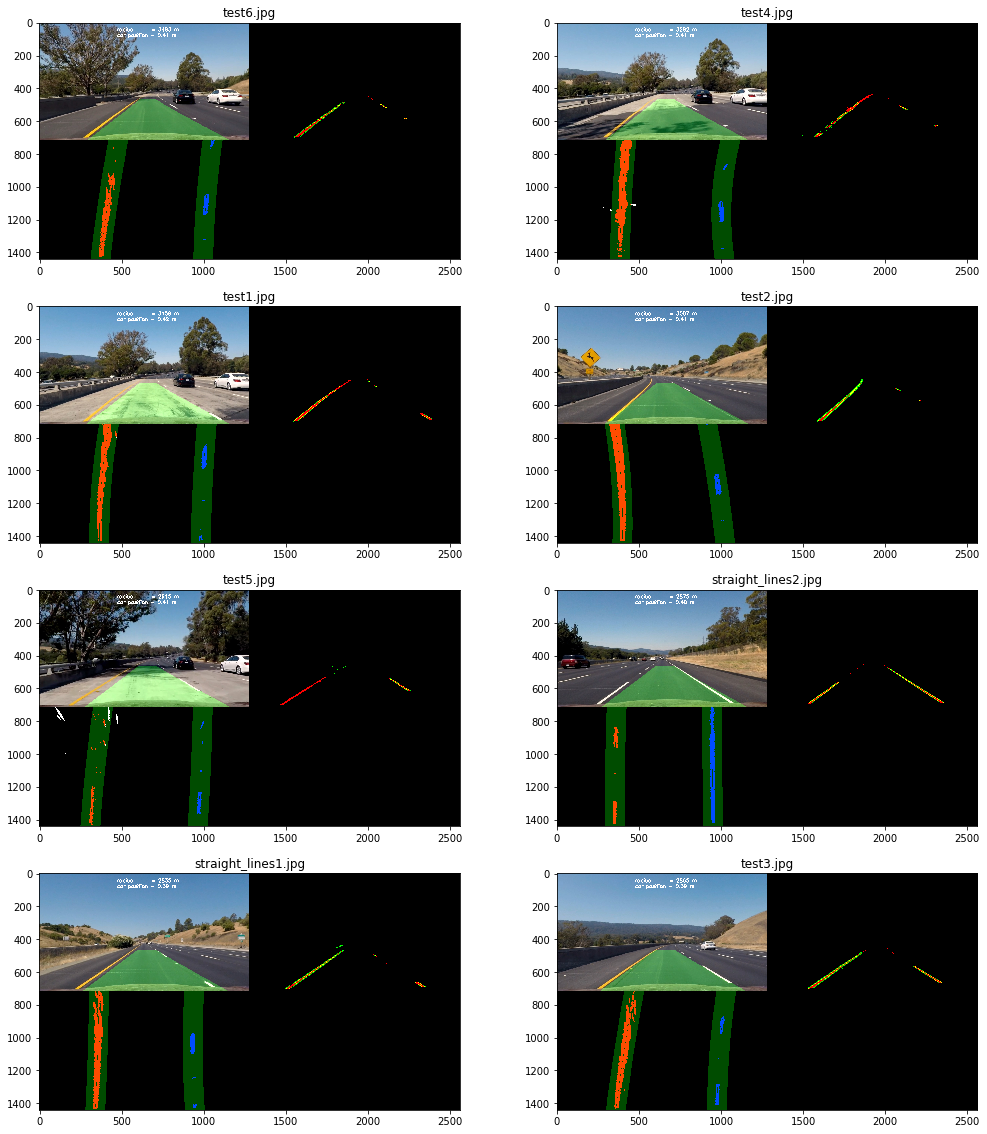

In [26]:
plt.figure(figsize=(17,20))
plot_shape = (n_images//2, 2)         # to display calibration images

THR_RED = 220, 255
THR_SAT = 60, 255

for i in range(8):
    first_time  = True
    pipeline_debug(images_raw[i]) # first frame
    im_lane = pipeline_debug(images_raw[i])
    plt.subplot(plot_shape[0],plot_shape[1],i+1)
    plt.imshow(im_lane)
    plt.title(names[i])